In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def show_state(state):
    plt.subplot(1,3,1)
    plt.imshow(state[:,:,0])
    plt.title('o')
    plt.clim(0,1)

    ax = plt.gca()
    ax.set_xticks(np.arange(0, 3, 1))
    ax.set_yticks(np.arange(0, 3, 1))
    ax.set_xticks(np.arange(-.5, 3.5, 1), minor=True)
    ax.set_yticks(np.arange(-.5, 3.5, 1), minor=True)
    ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

    plt.subplot(1,3,2)
    plt.imshow(state[:,:,1])
    plt.title('x')
    plt.clim(0,1)

    ax = plt.gca()
    ax.set_xticks(np.arange(0, 3, 1))
    ax.set_yticks(np.arange(0, 3, 1))
    ax.set_xticks(np.arange(-.5, 3.5, 1), minor=True)
    ax.set_yticks(np.arange(-.5, 3.5, 1), minor=True)
    ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
    
    plt.subplot(1,3,3)
    plt.imshow(state[:,:,2])
    plt.title('move')
    plt.clim(0,1)

    ax = plt.gca()
    ax.set_xticks(np.arange(0, 3, 1))
    ax.set_yticks(np.arange(0, 3, 1))
    ax.set_xticks(np.arange(-.5, 3.5, 1), minor=True)
    ax.set_yticks(np.arange(-.5, 3.5, 1), minor=True)
    ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

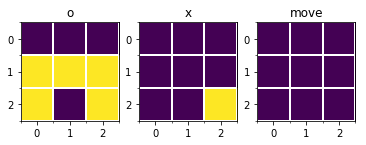

In [3]:
import numpy as np

# 1チャンネル目が○、2チャンネル目が×, 3チャンネル目が手番

board = np.zeros((3,3,3))
board[:,:,0] = 1

board = np.random.random((3,3,3))
board = board>0.8
#board[:,:,1] = board[:,:,0]-1
board[:,:,-1] = 0

show_state(board)

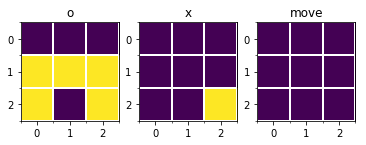

In [4]:
show_state(board)

In [5]:
from keras.layers import Input, Conv2D, Activation, BatchNormalization, Flatten, Dense
from keras.models import Model

state = h = Input((3,3,3))

h = Conv2D(4, (3,3), padding='same')(h)
h = BatchNormalization()(h)
h = Activation('relu')(h)

h = Conv2D(4, (3,3), padding='same')(h)
h = BatchNormalization()(h)
h = Activation('relu')(h)

h = Flatten()(h)
value = Dense(1)(h)

value_function = Model(state, value)
value_function.compile(loss='mse', optimizer='adam')
value_function.summary()

/Users/ruhokondo/Programming/anaconda3/envs/dl35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/ruhokondo/Programming/anaconda3/envs/dl35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3, 3, 3)           0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 3, 3, 4)           112       
_________________________________________________________________
batch_normalization_1 (Batch (None, 3, 3, 4)           16        
_________________________________________________________________
activation_1 (Activation)    (None, 3, 3, 4)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 4)           148       
_________________________________________________________________
batch_normalization_2 (Batch (None, 3, 3, 4)           16        
_________________________________________________________________
activation_2 (Activation)    (None, 3, 3, 4)           0         
__________

In [6]:
def get_permitted_actions(state):
    '''
    ○および×が置かれていない座標インデックスを返す。
    '''
    return np.where(state[:,:,0]+state[:,:,1]==0)

In [7]:
import copy

def transition(current_state, action):
    '''
    action は ○ もしくは × を置く state のインデックス。
    2チャンネル目が手番を表しているので、遷移後は手番を入れ替える。
    '''
    next_state = copy.deepcopy(current_state)
    if current_state[:,:,-1][0,0]==0: # ○の手番の場合
        next_state[action+(0,)] = 1
        next_state[:,:,-1] = np.ones((3,3))
    else: # ×の手番の場合
        next_state[action+(1,)] = 1
        next_state[:,:,-1] = np.zeros((3,3))
    return next_state

In [8]:
def get_best_action(current_state, value_function):
    '''
    行動空間が狭いので全探索する。
    '''
    a0,a1 = get_permitted_actions(current_state)
    max_value = -1e100
    for action in zip(a0,a1):
        next_state = transition(current_state, action)
        next_value = value_function.predict(np.expand_dims(next_state,0)).squeeze() # バッチの次元を拡張して入力する。
        if next_value>max_value:
            max_value = next_value
            best_action = action
    return max_value, best_action

In [9]:
nb_line = 3

def judge_game(state):
    winner = None
    checked = np.zeros(state.shape[:2])
    
    try:
        for i in range(state.shape[0]):
            for j in range(state.shape[1]):
                s = state[i,j,:2].argmax(-1)

                # 右側をチェック
                count = 0
                for jj in range(j,j+nb_line):
                    if state[i,jj,s]==1:
                        count += 1
                    if count==nb_line:
                        winner = s
                        raise Exception
                    
                # 下側をチェック
                count = 0
                for ii in range(i,i+nb_line):
                    if state[ii,j,s]==1:
                        count += 1
                    if count==nb_line:
                        winner = s
                        raise Exception
                        
                # 右下をチェック
                count = 0
                for ii,jj in zip(range(i,i+nb_line),range(j,j+nb_line)):
                    if state[ii,jj,s]==1:
                        count += 1
                    if count==nb_line:
                        winner = s
                        raise Exception
                        
                # 左下をチェック
                count = 0
                for ii,jj in zip(range(i,i-nb_line),range(j,j+nb_line)):
                    if state[ii,jj,s]==1:
                        count += 1
                    if count==nb_line:
                        winner = s
                        raise Exception
                        
    except Exception:
        pass
    
    return winner

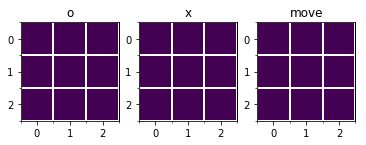

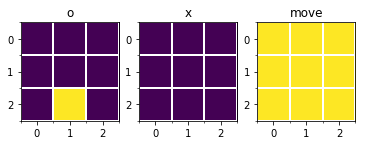

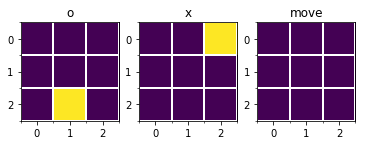

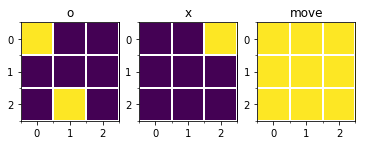

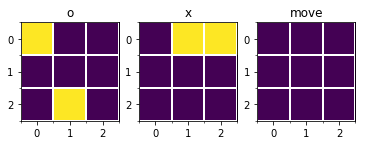

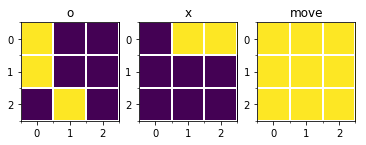

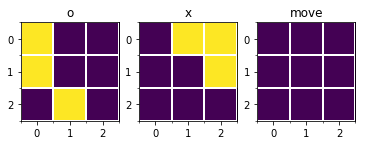

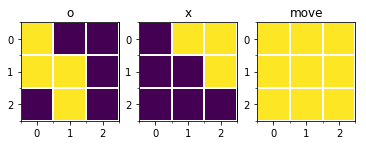

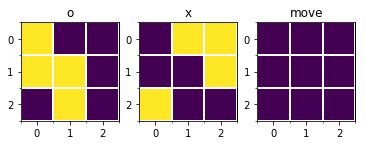

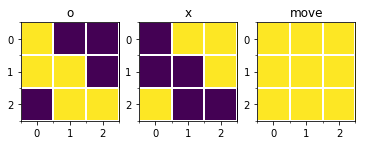

winner is 0


In [10]:
# 状態の初期化
current_state = np.zeros((3,3,3))
current_state[:,:,-1] = 0 # ○を先手とする。

show_state(current_state)
plt.show()

try:
    for _ in range(9):
        # 状態価値が最も高い行動を選択する。
        max_value, best_action = get_best_action(current_state, value_function)

        # 状態を更新する。
        current_state = transition(current_state, best_action)

        # 盤面の表示
        show_state(current_state)
        plt.show()

        # ゲームの終了判定
        winner = judge_game(current_state)
        
        if winner is not None:
            raise Exception

except Exception:
    pass

if winner is None:
    print('draw')
else:
    print('winner is '+str(winner))